<a href="https://colab.research.google.com/github/Gr-30/DL/blob/main/Assign4_Q2_Twitter_114_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- Libraries are important and we call them to perform the different actions on our data and for training the models.
- Its a first step to load the library to perform the specific task

# Import Libraries/Dataset

## Import the required libraries and the dataset.

In [38]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
nltk.download('stopwords')
nltk.download('wordnet')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Check the GPU available

In [5]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Data Visualization

In [25]:
data = pd.read_csv("/content/drive/MyDrive/Assignment1/training.1600000.processed.noemoticon.csv", encoding = "ISO-8859-1", engine="python", header=None)
 # As the data has no column titles, we will add our own
data.columns = ["label", "time", "date", "query", "username", "text"]

## Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text.

In [26]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
data.label = data.label.apply(lambda x: label_decoder(x))
data.head()

,label,time,date,query,username,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [15]:
#data.columns = ["label", "time", "date", "query", "username", "text"]

In [27]:
df_pos = data[data['label'] == "Positive"]
df_neg = data[data['label'] == "Negative"]

In [18]:
print('POSITIVE Label data ')
df_pos.head()



POSITIVE Label data 


,label,time,date,query,username,text
799999,Positive,1467822272,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,ersle,I LOVE @Health4UandPets u guys r the best!!
800000,Positive,1467822273,Mon Apr 06 22:22:45 PDT 2009,NO_QUERY,becca210,im meeting up with one of my besties tonight! ...
800001,Positive,1467822283,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,Wingman29,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800002,Positive,1467822287,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,katarinka,Being sick can be really cheap when it hurts t...
800003,Positive,1467822293,Mon Apr 06 22:22:46 PDT 2009,NO_QUERY,_EmilyYoung,@LovesBrooklyn2 he has that effect on everyone


In [19]:
print('Negative Label data ')
df_neg.head()

Negative Label data 


,label,time,date,query,username,text
0,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,Negative,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#### Five top records of data

In [ ]:
data.head()

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


#### Five last records of data

In [ ]:
data.tail()

,label,time,date,query,username,text
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


#### Coloumns/features in data

In [ ]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [28]:
data['label'].value_counts()

Negative    800000
Positive    800000
Name: label, dtype: int64

#### Length of data

In [29]:
print('lenght of data is', len(data))

lenght of data is 1600000


#### Shape of data

In [30]:
data.shape

(1600000, 6)

#### Data information

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   label     1600000 non-null  object
 1   time      1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   username  1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(1), object(5)
memory usage: 73.2+ MB


#### Data types of all coloumns

In [32]:
data.dtypes

label       object
time         int64
date        object
query       object
username    object
text        object
dtype: object

#### Checking Null values

In [ ]:
np.sum(data.isnull().any(axis=1))

0

#### Rows and columns in the dataset

In [ ]:
print('Count of columns in the data is:  ', len(data.columns))

Count of columns in the data is:   6


In [33]:
print('Count of rows in the data is:  ', len(data))

Count of rows in the data is:   1600000


In [ ]:
data=data[['text','label']]

## Plot a bar graph of class distribution in a dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

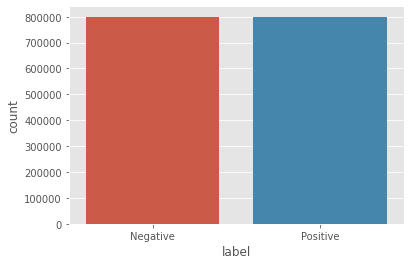

In [36]:
datag = data.groupby('label').size().reset_index(name='count')
sns.barplot(y="count",x="label", data=datag)


## Other visualizations

In [40]:
stopwords_ = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        collocations=False,
        background_color='white',
        stopwords=stopwords_,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

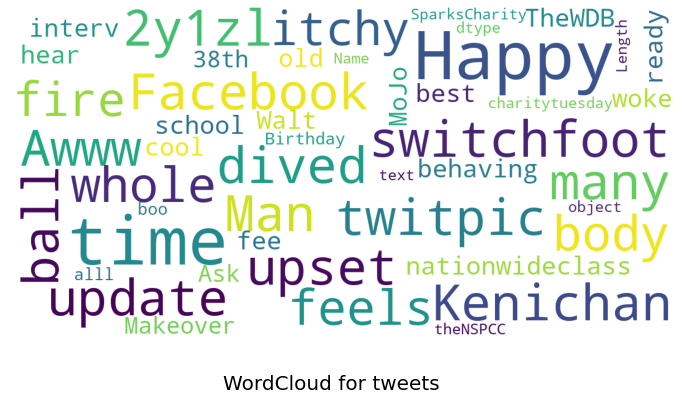

In [41]:
show_wordcloud(data['text'], "WordCloud for tweets")

# Data Pre-processing

#### Assigning 1 to Positive sentment 4

In [43]:
data['label'][data['label']==4]=1

In [44]:
embeddings = embed(data.text.values)

In [46]:
embeddings.shape

TensorShape([1600000, 128])

####  Separating input feature and label

In [42]:
X=embeddings.numpy()
y=data.label

NameError: ignored

#### Preparing the input features for training 

#### Separating the 70% data for training data and 30% for testing data

As we prepared all the tweets, now we are separating/splitting the tweets into training data and testing data.
- 70% tweets will be used in the training 
- 30% tweets will be used to test the performance of the model.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3, random_state=2)

In [ ]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('Y_train: ', Y_train.shape)
print('Y_test: ', Y_test.shape)

X_train:  (1119999, 128)
X_test:  (480000, 128)
Y_train:  (1119999,)
Y_test:  (480000,)


In [ ]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=(128))
    layer = Dense(64,name='layer1')(inputs)
    layer = Activation('relu')(layer)
    layer = Dense(32,name='layer2')(layer) 
    layer = Activation('relu')(layer)
    layer = Dense(16,name='layer3')(layer) 
    layer = Activation('relu')(layer)
    layer = Dense(1,name='output')(layer) 
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3, verbose=1,mode='auto', baseline=None, restore_best_weights=False
)

# Model compilation

In [ ]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(learning_rate=0.005),metrics=['accuracy'])  

In [ ]:
history=model.fit(X_train,Y_train,batch_size=128,epochs=100, validation_split=0.1, callbacks=[callback])# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/100
7875/7875 [==============================] - 14s 2ms/step - loss: 0.5569 - accuracy: 0.7114 - val_loss: 0.5386 - val_accuracy: 0.7250
Epoch 2/100
7875/7875 [==============================] - 13s 2ms/step - loss: 0.5324 - accuracy: 0.7311 - val_loss: 0.5301 - val_accuracy: 0.7321
Epoch 3/100
7875/7875 [==============================] - 13s 2ms/step - loss: 0.5278 - accuracy: 0.7344 - val_loss: 0.5276 - val_accuracy: 0.7347
Epoch 4/100
7875/7875 [==============================] - 13s 2ms/step - loss: 0.5252 - accuracy: 0.7363 - val_loss: 0.5322 - val_accuracy: 0.7282
Epoch 5/100
7875/7875 [==============================] - 13s 2ms/step - loss: 0.5249 - accuracy: 0.7370 - val_loss: 0.5301 - val_accuracy: 0.7356
Epoch 6/100
7875/7875 [==============================] - 13s 2ms/step - loss: 0.5247 - accuracy: 0.7380 - val_loss: 0.5316 - val_accuracy: 0.7354
Epoch 00006: early stopping
Training finished !!


#### Testing the Trained model on test data
- Getting predictions/classifying the sentiments (positve/negative) on the test data using trained model.

In [ ]:
accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here

15000/15000 [==============================] - 21s 1ms/step - loss: 0.5396 - accuracy: 0.7314


In [ ]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1])) #the accuracy of the model on test data is given below

Test set
  Accuracy: 0.73


In [ ]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)



confusion matrix


[[173158  66564]
 [ 60507 179771]]




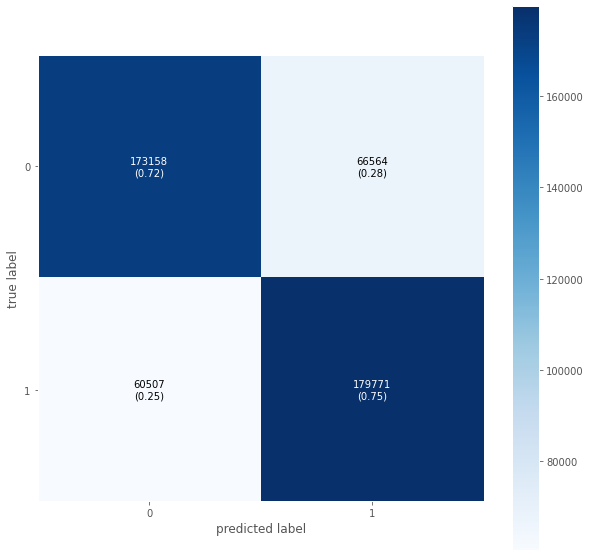

In [ ]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

# ROC CURVE

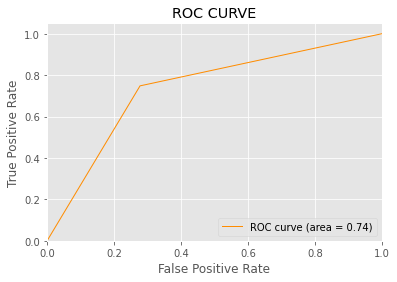

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()